# Testing local GPU vs. Colab GPUs performance using Resnet18 classifier on CIFAR-100 dataset with PyTorch




In [0]:
import torch
from torch import nn, optim
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
import numpy as np
import pandas as pd
import re
import os

In [0]:
# Settings and parameters

# Runtime settings
local_runtime = False    # local runtime with CUDA on Win10
use_gpu = True
gdrive_mounted = True

# Try to use CUDA only if available
gpu_selected_and_available = use_gpu & torch.cuda.is_available()

# Experiment parameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 10
selected_criterion = nn.CrossEntropyLoss
selected_optimizer = optim.SGD

In [0]:
# Print backend info

print('Backend info:')

if local_runtime:
    if gpu_selected_and_available:
        !"C:\\Program Files\\NVIDIA Corporation\\NVSMI\\nvidia-smi.exe"
    else:
        !wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status
else:
    if gpu_selected_and_available:
        !nvidia-smi
    else:
        !cat /proc/cpuinfo

Backend info:
Thu Mar 19 10:37:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Mem

In [0]:
# Directory settings - restart runtime if runtime settings changed!

if not local_runtime:
    if gdrive_mounted:
        work_dir = '/content/drive/My Drive/GPU_tests/Resnet_GPU_tests'
    else:
        work_dir = '/content/GAN_GPU_tests'
else:
    work_dir = 'C://OtherProjects//GPU_tests//Resnet_GPU_tests'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

if gpu_selected_and_available:
    if local_runtime:
        device_name = !"C:\\Program Files\\NVIDIA Corporation\\NVSMI\\nvidia-smi.exe" --query-gpu=name --format=csv,noheader
        device_name = device_name[0]
    else:
        device_name = !nvidia-smi --query-gpu=name --format=csv,noheader
        device_name = device_name[0]
else:
    if local_runtime:
        device_name = 'Local_CPU'
    else:
        device_name = 'Colab_CPU'

data_path = os.path.join(os.getcwd(), 'data')
save_dir = os.path.join(os.getcwd(), 'results',
                        re.sub(' ', '_', device_name) + '_' +\
                        re.sub('-| |:', '', str(datetime.now()).split('.')[0]))
os.makedirs(save_dir, exist_ok=True)

In [0]:
# Load PyTorch implementation of Resnet18

model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Adapt last layer for 100 classes instead of 1000

model.fc = nn.Linear(in_features=512, out_features=100, bias=True)

if gpu_selected_and_available:
    model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Define data transformations

trs = transforms.Compose([  
    transforms.Resize(260),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [0]:
# Load and transform training and validation datasets

train_dataset = datasets.CIFAR100(data_path, train=True,
                                  transform=trs, download=True)
valid_dataset = datasets.CIFAR100(data_path, train=False,
                                  transform=trs, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Create data loaders

train_data_gen = torch.utils.data.DataLoader(train_dataset, batch_size,
                                             num_workers=1, pin_memory=False)
valid_data_gen = torch.utils.data.DataLoader(valid_dataset, batch_size,
                                             num_workers=1, pin_memory=False)

dataloaders = {'train': train_data_gen,
               'valid': valid_data_gen}

dataset_sizes = {'train': len(train_data_gen.dataset),
                 'valid': len(valid_data_gen.dataset)}

In [0]:
# Loss function and optimizer

criterion = selected_criterion()
optimizer = selected_optimizer(model.parameters(), lr=learning_rate)

In [0]:
# Training procedure

def train_model(model, criterion, optimizer, num_epochs=1):

    best_model_weigths = model.state_dict()
    best_acc = 0.0

    stats = {'Epoch': [],
             'Epoch_time': [],
             'Epoch_train_loss': [],
             'Epoch_valid_loss': [],
             'Epoch_train_accuracy': [],
             'Epoch_valid_accuracy': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        t0 = time()
        # stat_dic = {}

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data

                if next(model.parameters()).is_cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Record statistics
                running_loss += loss.detach().item()
                running_corrects += torch.sum(preds == labels.data).detach().item()

            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
                stats['Epoch_train_loss'].append(epoch_loss)
                stats['Epoch_train_accuracy'].append(epoch_acc)
                print(f'Training loss: {epoch_loss:.4f}\n'
                      f'Training accuracy: {epoch_acc:.4f}')
            else:
                stats['Epoch_valid_loss'].append(epoch_loss)
                stats['Epoch_valid_accuracy'].append(epoch_acc)
                print(f'Validation loss: {epoch_loss:.4f}\n'
                      f'Validation accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weigths = model.state_dict()
        
        stats['Epoch'].append(epoch + 1)
        epoch_time = time() - t0
        stats['Epoch_time'].append(epoch_time)
        print(f'Epoch time: {epoch_time:.1f} secs')
        print()

    total_time = sum(stats['Epoch_time'])
    print('Training complete in {:.0f}m {:.0f}s'.format(
           total_time // 60, total_time % 60))
    print(f'Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_weigths)
    return model, stats

In [12]:
# Run training

model, stats = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------
Training loss: 0.0693
Training accuracy: 0.0530
Validation loss: 0.0644
Validation accuracy: 0.1217
Epoch time: 327.3 secs

Epoch 2/10
----------
Training loss: 0.0594
Training accuracy: 0.1972
Validation loss: 0.0546
Validation accuracy: 0.2667
Epoch time: 328.9 secs

Epoch 3/10
----------
Training loss: 0.0504
Training accuracy: 0.3211
Validation loss: 0.0461
Validation accuracy: 0.3689
Epoch time: 329.2 secs

Epoch 4/10
----------
Training loss: 0.0430
Training accuracy: 0.4128
Validation loss: 0.0397
Validation accuracy: 0.4495
Epoch time: 328.6 secs

Epoch 5/10
----------
Training loss: 0.0374
Training accuracy: 0.4826
Validation loss: 0.0348
Validation accuracy: 0.4995
Epoch time: 328.6 secs

Epoch 6/10
----------
Training loss: 0.0331
Training accuracy: 0.5326
Validation loss: 0.0311
Validation accuracy: 0.5400
Epoch time: 327.7 secs

Epoch 7/10
----------
Training loss: 0.0298
Training accuracy: 0.5688
Validation loss: 0.0282
Validation accuracy: 0.5731
Ep

In [0]:
# Save stats
stats_df = pd.DataFrame(stats)
stats_df.to_csv(os.path.join(save_dir, 'stats.csv'), index=False)

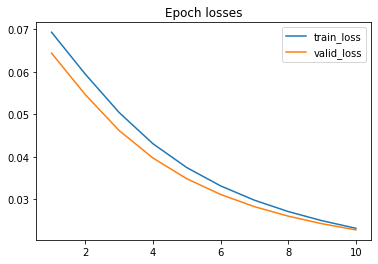

In [14]:
# Print and save epoch losses plot
plt.plot(stats['Epoch'], stats['Epoch_train_loss'])
plt.plot(stats['Epoch'], stats['Epoch_valid_loss'])
plt.title('Epoch losses')
plt.legend(['train_loss', 'valid_loss'])
plt.savefig(os.path.join(save_dir, 'epoch_losses.png'))

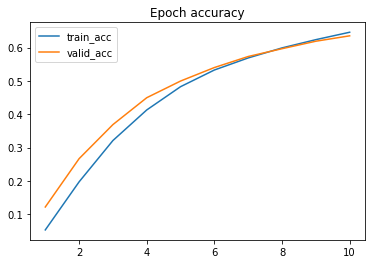

In [15]:
# Print and save epoch accuracy plot
plt.plot(stats['Epoch'], stats['Epoch_train_accuracy'])
plt.plot(stats['Epoch'], stats['Epoch_valid_accuracy'])
plt.title('Epoch accuracy')
plt.legend(['train_acc', 'valid_acc'])
plt.savefig(os.path.join(save_dir, 'epoch_accuracy.png'))

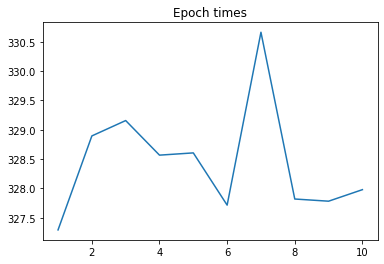

In [16]:
# Print and save epoch times plot
plt.plot(stats['Epoch'], stats['Epoch_time'])
plt.title('Epoch times')
plt.savefig(os.path.join(save_dir, 'epoch_times.png'))